In [1]:
from typing import Literal, List
from pydantic import BaseModel
from pydantic_ai import Agent
from dotenv import load_dotenv
import json
import nest_asyncio
from pydantic_ai.models.openai import OpenAIChatModel
from pydantic_ai.providers.openai import OpenAIProvider
from tenacity import stop_after_attempt

from httpx import AsyncClient, HTTPStatusError
from tenacity import retry_if_exception_type, wait_exponential

from pydantic_ai.retries import AsyncTenacityTransport, RetryConfig, wait_retry_after


nest_asyncio.apply()

load_dotenv()


class HyperParams(BaseModel):
    hidden_size: Literal[64, 128, 256, 512]
    n_head: Literal[4, 8, 16]
    dropout: Literal[0, 0.05, 0.1, 0.2, 0.5]
    conv_hidden_size: Literal[16, 32, 64, 128]
    distil: Literal[True, False]
    activation: Literal["relu", "gelu"]
    encoder_layers: Literal[2, 3, 4, 6]
    decoder_layers: Literal[2]
    learning_rate: Literal[1e-4]
    scaler_type: Literal["robust"]
    max_steps: Literal[8]
    batch_size: Literal[32]
    windows_batch_size: Literal[1024]
    random_seed: Literal[1]


class HistoryEntry(BaseModel):
    params: HyperParams
    metric: float


class SuggestionInput(BaseModel):
    optimize_direction: Literal["minimize", "maximize"] = "minimize"
    history: List[HistoryEntry] | None = None


# -----------------------------------------------------------
# 3. Агент pydantic-ai
# -----------------------------------------------------------
def create_retrying_client():
    """Create a client with smart retry handling for multiple error types."""

    def should_retry_status(response):
        """Raise exceptions for retryable HTTP status codes."""
        if response.status_code in (429, 403, 502, 503, 504):
            response.raise_for_status()  # This will raise HTTPStatusError

    transport = AsyncTenacityTransport(
        config=RetryConfig(
            # Retry on HTTP errors and connection issues
            retry=retry_if_exception_type((HTTPStatusError, ConnectionError)),
            # Smart waiting: respects Retry-After headers, falls back to exponential backoff
            wait=wait_retry_after(
                fallback_strategy=wait_exponential(multiplier=1, max=60), max_wait=300
            ),
            # Stop after 5 attempts
            stop=stop_after_attempt(5),
            # Re-raise the last exception if all retries fail
            reraise=True,
        ),
        validate_response=should_retry_status,
    )
    return AsyncClient(transport=transport)


# Use the retrying client with a model
client = create_retrying_client()

model = OpenAIChatModel(
    "qwen/qwen3-8b",
    provider=OpenAIProvider(),
)

agent = Agent(
    model=model,
    instructions=(
        "You are an AutoML hyperparameter optimization expert. "
        "You receive:\n"
        " - history of tried parameters with metric\n"
        " - optimization direction\n"
        " - fixed categorical hyperparameter search space\n\n"
        "Your task:\n"
        " - analyze the history\n"
        " - choose the next promising point strictly inside the allowed search space\n"
        " - DO NOT repeat params from history\n"
    ),
    output_type=HyperParams,
)


# -----------------------------------------------------------
# 4. Функция вызова: фиксированное пространство + history
# -----------------------------------------------------------


def suggest_params_with_history(
    *,
    optimize_direction: Literal["minimize", "maximize"] = "minimize",
    history: list | None = None,
):
    history_text = (
        json.dumps([h for h in history], ensure_ascii=False, indent=2)
        if history
        else "[]"
    )

    result = agent.run_sync(
        user_prompt=(
            "Suggest the next hyperparameter configuration based on:\n"
            f"Optimization direction: {optimize_direction}\n\n"
            f"History:\n{history_text}\n\n"
            "Return parameters strictly from the allowed categorical space."
        ),
    )

    return result.output

In [2]:
direction = "minimize"
history = [
    {
        "params": {
            "input_size": 96,
            "hidden_size": 512,
            "n_head": 8,
            "dropout": 0.05,
            "conv_hidden_size": 32,
            "distil": True,
            "activation": "gelu",
            "encoder_layers": 3,
            "decoder_layers": 2,
            "learning_rate": 0.0001,
            "scaler_type": "robust",
            "max_steps": 8,
            "batch_size": 32,
            "windows_batch_size": 1024,
            "random_seed": 1,
        },
        "metric": 0.95,
    },
    {
        "params": {
            "input_size": 96,
            "hidden_size": 512,
            "n_head": 8,
            "dropout": 0.1,
            "conv_hidden_size": 64,
            "distil": False,
            "activation": "relu",
            "encoder_layers": 4,
            "decoder_layers": 2,
            "learning_rate": 0.0001,
            "scaler_type": "robust",
            "max_steps": 8,
            "batch_size": 32,
            "windows_batch_size": 1024,
            "random_seed": 1,
        },
        "metric": 0.96,
    },
]

new_params = suggest_params_with_history(history=history, optimize_direction=direction)

print("Suggested new parameters:")
print(new_params)

Suggested new parameters:
hidden_size=256 n_head=4 dropout=0.2 conv_hidden_size=16 distil=False activation='gelu' encoder_layers=2 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1


In [3]:
from datasetsforecast.long_horizon2 import LongHorizon2, ETTh1
import pandas as pd

In [4]:
Y_df = LongHorizon2.load(directory="data", group="ETTh1")
Y_df["ds"] = pd.to_datetime(Y_df["ds"])

n_time = len(Y_df.ds.unique())
val_size = int(0.2 * n_time)
test_size = int(0.2 * n_time)

Y_df

,index,ds,unique_id,y
0,0,2016-07-01 00:00:00,HUFL,-0.279827
1,1,2016-07-01 01:00:00,HUFL,-0.301290
2,2,2016-07-01 02:00:00,HUFL,-0.387142
3,3,2016-07-01 03:00:00,HUFL,-0.397873
4,4,2016-07-01 04:00:00,HUFL,-0.354948
...,...,...,...,...
100795,118915,2018-02-20 19:00:00,OT,-2.003877
100796,118916,2018-02-20 20:00:00,OT,-2.003877
100797,118917,2018-02-20 21:00:00,OT,-1.776565
100798,118918,2018-02-20 22:00:00,OT,-1.742809


In [5]:
from neuralforecast import NeuralForecast
from neuralforecast.auto import Informer
from neuralforecast.losses.pytorch import MSE
from neuralforecast.losses.numpy import mse
import torch


In [7]:
torch.set_float32_matmul_precision("high")

horizon = ETTh1.horizons[0]
n_trials = 25
optimize_direction = "minimize"
history = []

best_metric = float("inf")
best_params = None

for trial in range(n_trials):
    print(f"=== Trial {trial + 1} ===")

    # Suggest new hyperparameters
    new_params = suggest_params_with_history(
        optimize_direction=optimize_direction,
        history=history,
    )

    # Train Informer with suggested parameters
    nf = NeuralForecast(
        models=[
            Informer(h=horizon, loss=MSE(), input_size=horizon, **dict(new_params))
        ],
        freq="h",
    )
    Y_hat_df = nf.cross_validation(
        df=Y_df, val_size=val_size, test_size=test_size, n_windows=None
    )

    metric_value = nf.models[0].metrics["ptl/val_loss"].item()

    print(
        f"Trial {trial + 1} finished with value: {metric_value:.4f} and parameters: {new_params}"
    )

    # Update best if improved
    if metric_value < best_metric:
        best_metric = metric_value
        best_params = dict(new_params)

    # Append to history
    history.append({"params": dict(new_params), "metric": metric_value})

print(f"=== Best hyperparameters after {n_trials} trials ===")
print(best_params)
print(f"Best metric: {best_metric:.4f}")


=== Trial 1 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 1 finished with value: 1.0059 and parameters: hidden_size=128 n_head=8 dropout=0.1 conv_hidden_size=64 distil=True activation='gelu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 2 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 2 finished with value: 0.9863 and parameters: hidden_size=256 n_head=4 dropout=0.05 conv_hidden_size=128 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 3 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 3 finished with value: 1.0950 and parameters: hidden_size=64 n_head=16 dropout=0.2 conv_hidden_size=16 distil=True activation='relu' encoder_layers=2 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 4 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 4 finished with value: 0.9868 and parameters: hidden_size=256 n_head=8 dropout=0.1 conv_hidden_size=64 distil=True activation='gelu' encoder_layers=2 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 5 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 5 finished with value: 0.9955 and parameters: hidden_size=128 n_head=4 dropout=0.2 conv_hidden_size=128 distil=False activation='gelu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 6 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 6 finished with value: 1.0463 and parameters: hidden_size=64 n_head=8 dropout=0.05 conv_hidden_size=128 distil=False activation='gelu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 7 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 7 finished with value: 0.9906 and parameters: hidden_size=256 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=6 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 8 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 8 finished with value: 0.9868 and parameters: hidden_size=128 n_head=4 dropout=0.05 conv_hidden_size=32 distil=False activation='relu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 9 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 9 finished with value: 0.9740 and parameters: hidden_size=256 n_head=4 dropout=0.1 conv_hidden_size=64 distil=True activation='gelu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 10 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 10 finished with value: 1.0287 and parameters: hidden_size=128 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 11 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 11 finished with value: 1.0400 and parameters: hidden_size=64 n_head=8 dropout=0.2 conv_hidden_size=32 distil=True activation='gelu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 12 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 12 finished with value: 0.9898 and parameters: hidden_size=128 n_head=4 dropout=0.05 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 13 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 13 finished with value: 0.8551 and parameters: hidden_size=256 n_head=16 dropout=0.2 conv_hidden_size=32 distil=True activation='relu' encoder_layers=6 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 14 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 14 finished with value: 1.0053 and parameters: hidden_size=128 n_head=8 dropout=0.05 conv_hidden_size=128 distil=False activation='relu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 15 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 15 finished with value: 0.9906 and parameters: hidden_size=256 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=6 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 16 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 16 finished with value: 0.9898 and parameters: hidden_size=128 n_head=4 dropout=0.05 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 17 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 17 finished with value: 0.9906 and parameters: hidden_size=256 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=6 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 18 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 18 finished with value: 0.9873 and parameters: hidden_size=256 n_head=8 dropout=0.1 conv_hidden_size=128 distil=False activation='relu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 19 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 19 finished with value: 0.9906 and parameters: hidden_size=256 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=6 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 20 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 20 finished with value: 0.9899 and parameters: hidden_size=128 n_head=4 dropout=0.05 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 21 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 21 finished with value: 0.9906 and parameters: hidden_size=256 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=6 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 22 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 22 finished with value: 0.9872 and parameters: hidden_size=256 n_head=8 dropout=0.1 conv_hidden_size=128 distil=False activation='relu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 23 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 23 finished with value: 0.9873 and parameters: hidden_size=256 n_head=8 dropout=0.1 conv_hidden_size=128 distil=False activation='relu' encoder_layers=3 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 24 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 24 finished with value: 0.9925 and parameters: hidden_size=256 n_head=16 dropout=0.2 conv_hidden_size=32 distil=False activation='relu' encoder_layers=6 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Trial 25 ===


INFO:httpx:HTTP Request: POST http://10.45.224.85:1234/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_emb

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 25 finished with value: 1.0287 and parameters: hidden_size=128 n_head=16 dropout=0.1 conv_hidden_size=32 distil=False activation='relu' encoder_layers=4 decoder_layers=2 learning_rate=0.0001 scaler_type='robust' max_steps=8 batch_size=32 windows_batch_size=1024 random_seed=1
=== Best hyperparameters after 25 trials ===
{'hidden_size': 256, 'n_head': 16, 'dropout': 0.2, 'conv_hidden_size': 32, 'distil': True, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
Best metric: 0.8551


In [8]:
best_params

{'hidden_size': 256,
 'n_head': 16,
 'dropout': 0.2,
 'conv_hidden_size': 32,
 'distil': True,
 'activation': 'relu',
 'encoder_layers': 6,
 'decoder_layers': 2,
 'learning_rate': 0.0001,
 'scaler_type': 'robust',
 'max_steps': 8,
 'batch_size': 32,
 'windows_batch_size': 1024,
 'random_seed': 1}

In [10]:
nf = NeuralForecast(models=[Informer(h=horizon, input_size=horizon, loss=MSE(), **best_params)], freq="h")
Y_hat_df = nf.cross_validation(
    df=Y_df, val_size=val_size, test_size=test_size, n_windows=None
)

INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 768    | train
4 | dec_embedding | DataEmbedding | 768    | train
5 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_6372/3558308939.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]


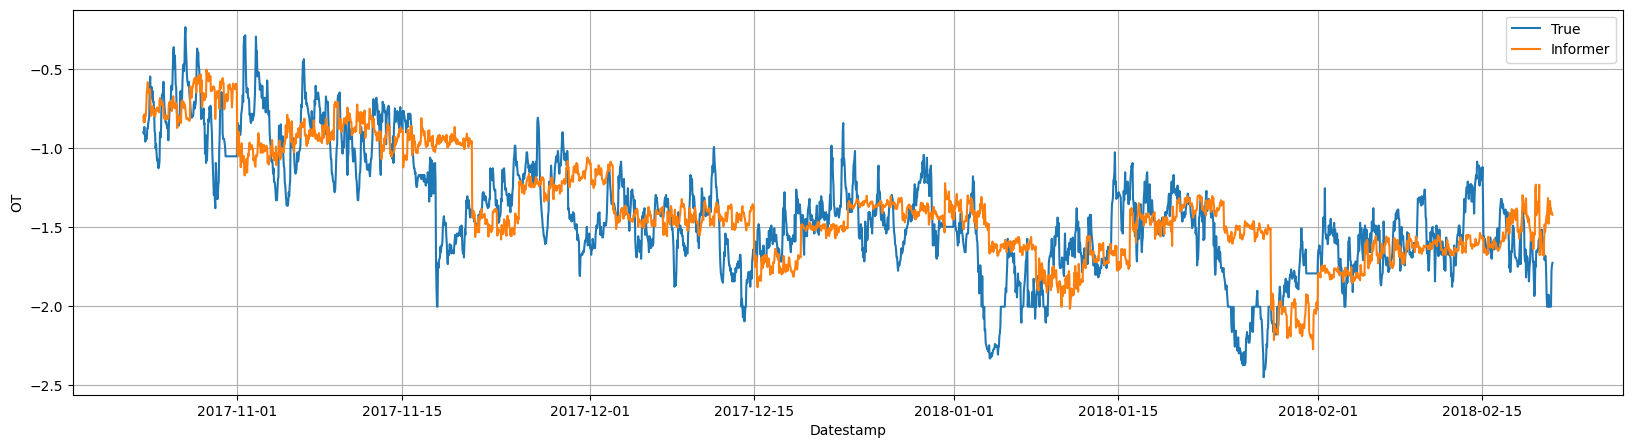

In [11]:
import matplotlib.pyplot as plt

Y_plot = Y_hat_df[Y_hat_df["unique_id"] == "OT"]  # OT dataset
cutoffs = Y_hat_df["cutoff"].unique()[::horizon]
Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]

plt.figure(figsize=(20, 5))
plt.plot(Y_plot["ds"], Y_plot["y"], label="True")
plt.plot(Y_plot["ds"], Y_plot["Informer"], label="Informer")
plt.xlabel("Datestamp")
plt.ylabel("OT")
plt.grid()
plt.legend();

In [12]:
mse_informer = mse(Y_hat_df["y"], Y_hat_df["Informer"])

print(f"Informer: {mse_informer:.3f}")

Informer: 0.553
